In [ ]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import torch.nn.functional as functional
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import seaborn

In [ ]:
classification_models = torchvision.models.list_models(module=torchvision.models)
print(classification_models)
torch.cuda.empty_cache()

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

#### **Загрузка данных**

In [ ]:
def download_datasets(transform):
  train_dataset = torchvision.datasets.CIFAR10(
      root = os.getcwd(), train = True, download = True,
      transform = transform
  )
  test_dataset = torchvision.datasets.CIFAR10(
      root = os.getcwd(), train = False, download = True,
      transform = transform
  )
  return train_dataset, test_dataset

In [ ]:
learning_rate = 0.001
num_epochs = 4
batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_function = torch.nn.CrossEntropyLoss()
test_accuracies_for_all_models = {}

def get_loaders(train_dataset, test_dataset):
  train_data_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size = batch_size, shuffle = True
  )
  test_data_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size = batch_size, shuffle = False
  )
  return train_data_loader, test_data_loader

def load_data(transform):
  train_dataset, test_dataset = download_datasets(transforms)
  train_data_loader, test_data_loader = get_loaders(train_dataset, test_dataset)
  return train_data_loader, test_data_loader

#### **Настройка обучения**

In [ ]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def epoch_acc(accuracies):
  return torch.stack(accuracies).mean()

def epoch_loss(losses):
  return torch.stack(losses).mean()

In [ ]:
def train(model, data_loader, epochs, loss_function, optimizer, device):
  start_total_time = time.time()
  print('Обучающая выборка:')

  for epoch in range(epochs):
    start_epoch_time = time.time()
    accuracies = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)

        loss.backward()
        optimizer.step()

    time_epoch = time.time() - start_epoch_time

    print(f'Эпоха {epoch}: потери = {epoch_loss(losses)}, точность = {epoch_acc(accuracies)}, время выполнения = {time_epoch}')

  total_time = time.time() - start_total_time
  print(f'Общее время выполнения = {total_time}')

In [ ]:
def test_and_get_accuracy(model, test_data_loader, device):
  test_losses = get_loss(model, test_data_loader, device)
  test_accuracy = get_accuracy(model, test_data_loader, device)
  print(f'Тестовая выборка: потери = {test_losses}, точность = {test_accuracy}')
  return test_accuracy

#### **Изменение архитектуры**

In [ ]:
def change_last_layer_unfreezing_parameters(net, train_data_loader, test_data_loader, updated_layer):
  if hasattr(net, 'fc'):
        net.fc = updated_layer
  elif hasattr(net, 'classifier'):
        net.classifier = updated_layer

  optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

  return net, optimizer

def change_last_layer_freezing_parameters(net, train_data_loader, test_data_loader, updated_layer):
  #updated_layer.eval()
  for param in net.parameters():
    param.requires_grad = False
  if hasattr(net, 'fc'):
        net.fc = updated_layer
        #print(net.fc.weight.requires_grad)
        optimizer = torch.optim.Adam(net.fc.parameters(), lr = learning_rate)
  elif hasattr(net, 'classifier'):
        net.classifier = updated_layer
        optimizer = torch.optim.Adam(net.classifier.parameters(), lr = learning_rate)

  return net, optimizer

#### **Тренировка и обучение**

In [ ]:
def train_and_test(train_data_loader, test_data_loader, network, optimizer, network_name):
  network.to(device)

  print(network_name)
  train(network, train_data_loader, num_epochs, loss_function, optimizer, device)
  test_accuracy = test_and_get_accuracy(network, test_data_loader, device)
  test_accuracies_for_all_models[network_name] = test_accuracy.item()
  torch.cuda.empty_cache()

#### **ResNet18**

In [ ]:
weights = torchvision.models.ResNet18_Weights.DEFAULT
net = torchvision.models.resnet18(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = load_data(transforms)

new_layers = torch.nn.Linear(net.fc.in_features, 10)

network, optimizer = change_last_layer_unfreezing_parameters(net, train_data_loader, test_data_loader, new_layers)
print(network, '\n\n')
print(f'ResNet18: начальные веса = torchvision.models.ResNet18_Weights.DEFAULT, обучение всех слоев')
train_and_test(train_data_loader, test_data_loader, network, optimizer, 'ResNet18')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


100%|██████████| 170498071/170498071 [00:02<00:00, 69693145.74it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e

In [ ]:
net = torchvision.models.resnet18(weights)

network, optimizer = change_last_layer_freezing_parameters(net, train_data_loader, test_data_loader, new_layers)
print(f'ResNet18: начальные веса = torchvision.models.ResNet18_Weights.DEFAULT, заморозка слоев')
train_and_test(train_data_loader, test_data_loader, network, optimizer, 'ResNet18, frozen')

ResNet18: начальные веса = torchvision.models.ResNet18_Weights.DEFAULT, заморозка слоев
ResNet18, frozen
Обучающая выборка:
Эпоха 0: потери = 0.9658557176589966, точность = 0.6832800507545471, время выполнения = 175.0767207145691
Эпоха 1: потери = 0.7082768678665161, точность = 0.7566215991973877, время выполнения = 173.48671174049377
Эпоха 2: потери = 0.6641119718551636, точность = 0.7688379287719727, время выполнения = 174.0706377029419
Эпоха 3: потери = 0.6414754390716553, точность = 0.7778012752532959, время выполнения = 175.25822019577026
Общее время выполнения = 697.9076242446899
Тестовая выборка: потери = 0.00524479802697897, точность = 0.7708999514579773


#### **MobileNet_V3**

In [ ]:
weights = torchvision.models.MobileNet_V3_Large_Weights.DEFAULT
net = torchvision.models.mobilenet_v3_large(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = load_data(transforms)

new_layers = torch.nn.Sequential(
                torch.nn.Linear(960, 1280),
                torch.nn.Hardswish(),
                torch.nn.Dropout(0.2),
                torch.nn.Linear(1280, 10))

network, optimizer = change_last_layer_unfreezing_parameters(net, train_data_loader, test_data_loader, new_layers)
print(network, '\n\n')
print(f'MobileNet_V3: начальные веса = torch_model.MobileNet_V3_Large_Weights.DEFAULT, обучение всех слоев')
train_and_test(train_data_loader, test_data_loader, network, optimizer, 'MobileNet')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 86.3MB/s]


Files already downloaded and verified
Files already downloaded and verified
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormAct

In [ ]:
net = torchvision.models.mobilenet_v3_large(weights)

network_frozen, optimizer_frozen = change_last_layer_freezing_parameters(net, train_data_loader, test_data_loader, new_layers)
print(f'MobileNet_V3: начальные веса = torch_model.MobileNet_V3_Large_Weights.DEFAULT, заморозка слоев')
train_and_test(train_data_loader, test_data_loader, network_frozen, optimizer_frozen, 'MobileNet, frozen')

MobileNet_V3: начальные веса = torch_model.MobileNet_V3_Large_Weights.DEFAULT, заморозка слоев
MobileNet, frozen
Обучающая выборка:
Эпоха 0: потери = 0.7189369797706604, точность = 0.7462795972824097, время выполнения = 165.5106906890869
Эпоха 1: потери = 0.5962360501289368, точность = 0.7899177074432373, время выполнения = 165.10163950920105
Эпоха 2: потери = 0.5333257913589478, точность = 0.8094789385795593, время выполнения = 164.8393042087555
Эпоха 3: потери = 0.4743284583091736, точность = 0.8328325152397156, время выполнения = 166.26948189735413
Общее время выполнения = 661.7297995090485
Тестовая выборка: потери = 0.00489986315369606, точность = 0.788599967956543


#### **RegNet-Y-800MF**

In [ ]:
weights = torchvision.models.RegNet_Y_800MF_Weights.DEFAULT
net = torchvision.models.regnet_y_800mf(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = load_data(transforms)

new_layers = torch.nn.Linear(net.fc.in_features, 10)

network, optimizer = change_last_layer_unfreezing_parameters(net, train_data_loader, test_data_loader, new_layers)
print(network, '\n\n')
print(f'RegNet-Y-800MF: начальные веса = torch_model.RegNet_Y_800MF_Weights.DEFAULT, обучение всех слоев')
train_and_test(train_data_loader, test_data_loader, network, optimizer, 'RegNet')

Downloading: "https://download.pytorch.org/models/regnet_y_800mf-58fc7688.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-58fc7688.pth
100%|██████████| 24.8M/24.8M [00:00<00:00, 59.2MB/s]


Files already downloaded and verified
Files already downloaded and verified
RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_si

In [ ]:
net = torchvision.models.regnet_y_800mf(weights)

network_frozen, optimizer_frozen = change_last_layer_freezing_parameters(net, train_data_loader, test_data_loader, new_layers)
print(f'RegNet-Y-800MF: начальные веса = torch_model.RegNet_Y_800MF_Weights.DEFAULT, заморозка слоев')
train_and_test(train_data_loader, test_data_loader, network_frozen, optimizer_frozen, 'RegNet, frozen')

RegNet-Y-800MF: начальные веса = torch_model.RegNet_Y_800MF_Weights.DEFAULT, заморозка слоев
RegNet, frozen
Обучающая выборка:
Эпоха 0: потери = 0.8339899778366089, точность = 0.7267982959747314, время выполнения = 335.43816232681274
Эпоха 1: потери = 0.6548516750335693, точность = 0.7774216532707214, время выполнения = 332.54241275787354
Эпоха 2: потери = 0.6081427335739136, точность = 0.7917678952217102, время выполнения = 332.2864272594452
Эпоха 3: потери = 0.5847674608230591, точность = 0.7985773682594299, время выполнения = 332.56864500045776
Общее время выполнения = 1332.843736410141
Тестовая выборка: потери = 0.004878457169979811, точность = 0.7915999889373779


##### **GoogleNet**

In [ ]:
weights = torchvision.models.GoogLeNet_Weights.DEFAULT
net = torchvision.models.googlenet(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = load_data(transforms)

new_layers = torch.nn.Linear(net.fc.in_features, 10)

network, optimizer = change_last_layer_unfreezing_parameters(net, train_data_loader, test_data_loader, new_layers)
print(network, '\n\n')
print(f'GoogleNet: начальные веса = torchvision.models.GoogLeNet_Weights.DEFAULT, обучение всех слоев')
train_and_test(train_data_loader, test_data_loader, network, optimizer, 'GoogleNet')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 98.0MB/s]


Files already downloaded and verified
Files already downloaded and verified
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [ ]:
net = torchvision.models.googlenet(weights)

network_frozen, optimizer_frozen = change_last_layer_freezing_parameters(net, train_data_loader, test_data_loader, new_layers)
print(f'GoogleNet: начальные веса = torchvision.models.GoogLeNet_Weights.DEFAULT, заморозка слоев')
train_and_test(train_data_loader, test_data_loader, network_frozen, optimizer_frozen, 'GoogleNet, frozen')

GoogleNet: начальные веса = torchvision.models.GoogLeNet_Weights.DEFAULT, заморозка слоев
GoogleNet, frozen
Обучающая выборка:
Эпоха 0: потери = 1.0022772550582886, точность = 0.6817495226860046, время выполнения = 191.19353795051575
Эпоха 1: потери = 0.7564727067947388, точность = 0.7452046275138855, время выполнения = 187.2453751564026
Эпоха 2: потери = 0.7214899659156799, точность = 0.7559542655944824, время выполнения = 186.83468914031982
Эпоха 3: потери = 0.696009635925293, точность = 0.7623001933097839, время выполнения = 185.92819905281067
Общее время выполнения = 751.2103695869446
Тестовая выборка: потери = 0.005745618138462305, точность = 0.7534999847412109


#### **Построение гистограммы**

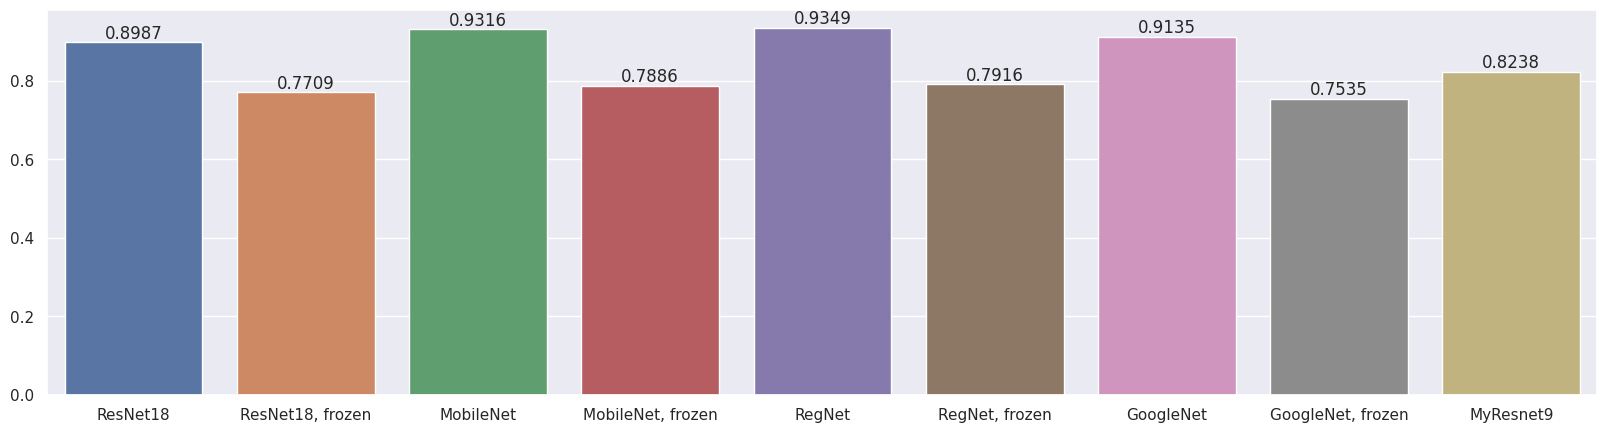

In [ ]:
test_accuracies_for_all_models['MyResnet9'] = 0.8237999677658081
x, y = zip(*[(k, v) for k, v in test_accuracies_for_all_models.items()])

seaborn.set(rc={'figure.figsize': (20, 5)})
ax = seaborn.barplot(x=list(x), y=list(y))
for i in ax.containers:
    ax.bar_label(i,)

#### **Итоги**

In [ ]:
max_value = max(test_accuracies_for_all_models.values())
best_net_name = ''

for key, value in test_accuracies_for_all_models.items():
  if value == max_value:
    best_net_name = key

print(f'Модель с наибольшей точностью: {best_net_name}. Точность: {max_value}')
print(f'Количество эпох: {num_epochs}, шаг обучения: {learning_rate}, размер батча: {batch_size}')

Модель с наибольшей точностью: RegNet. Точность: 0.9348999857902527
Количество эпох: 4, шаг обучения: 0.001, размер батча: 128
